# Demo of frequency analysis
## Author: M. R. Ware
## Date: 3/25/18

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import os
# os.environ['dropboxPath']='/home/mrware/Dropbox'
os.environ['dropboxPath']='C:/Users/mrwar/Dropbox'

import sys
sys.path.insert(0, os.environ['dropboxPath']+'/Code/mattsTools')

from mattsTools import *
addSubDirectoriesToPath('..')


from frequencyChiSquare import *
from budarzCorrection import *
from formFactors import *

## Sample data

The reconstructor takes a temporal slice from your time-resolved scattering data. Here we plot the full $\Delta$I(Q,T) map. 

Note I suggest restricting your data to regions where you know the signal is not attenuated. For this sample, that is the region above 1.5 $\overset{\circ}{A}^{-1}$

In [2]:
sampleData = fload_obj('Legendre_Data_74_v3')

../data/XPPL2816\Legendre_Data_74_v3 remembered!


In [3]:
print sampleData.keys()
print sampleData['legendres']

['Q', 'stdSignal', 'T', 'legendres', 'meanSignal']
[0, 2, 4]


(None, None)


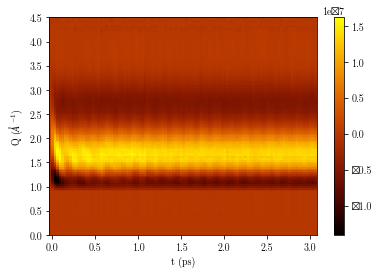

In [4]:
defaultMesh( sampleData['T'], sampleData['Q'], 
            sampleData['meanSignal'][0,:,:], xlabel='t (ps)', ylabel='Q ($\AA^{-1}$)'  )


## Apply relevant corrections and renormalize

-1
1.1


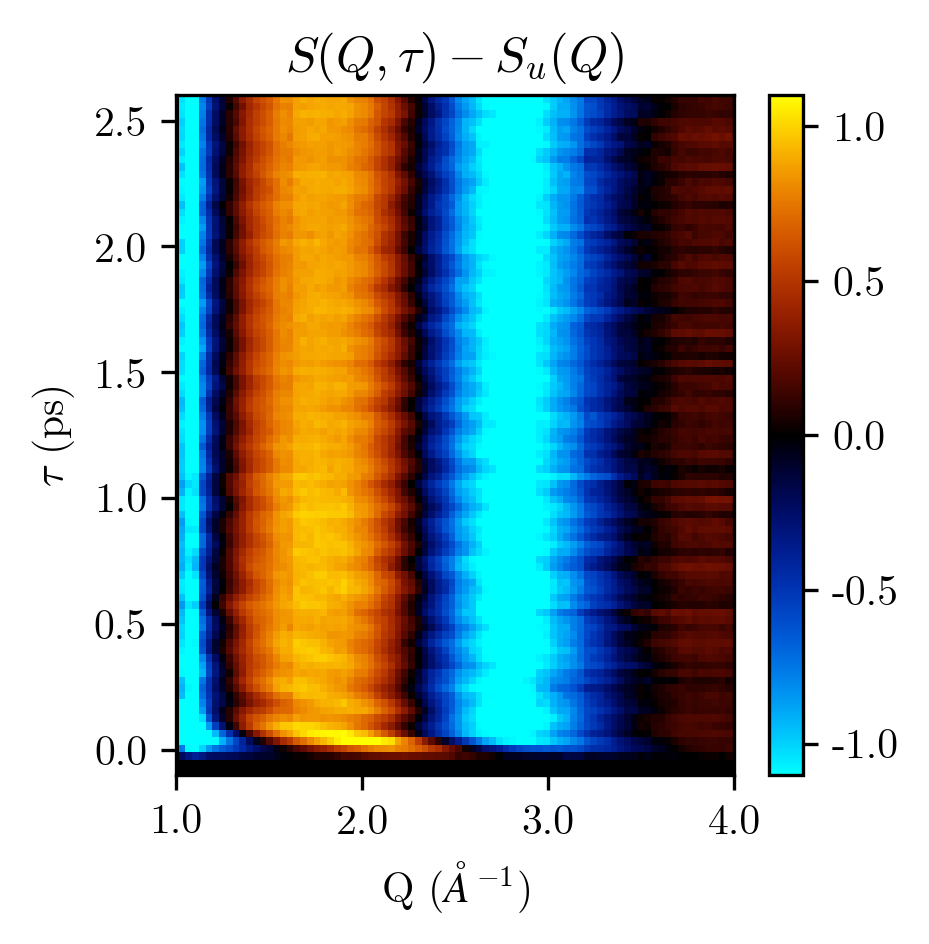

In [31]:
legendreOrder = 0
# qIndexes      = (sampleData['Q'] > 1.5)
# qIndexes      = (sampleData['Q'] > 1.0)&(sampleData['Q'] < 3.1)
qIndexes      = (sampleData['Q'] > 1.0)&(sampleData['Q'] < 4.5)

# Slice out data for analysis
legendreIndex   = (np.array(sampleData['legendres']) == legendreOrder)
Qs              = sampleData['Q'][qIndexes]


muData          = sampleData['meanSignal'][legendreIndex, qIndexes, :]
sigmaData       = sampleData['stdSignal'][legendreIndex, qIndexes, :]

# Generate correction factors
bC = budarzCorrection(np.ones_like(muData[:,0]),Qs,wavelength=1.3776)
fQI = fQ(Qs,'Iodine')

# Apply correction factors across all times
muCData = tileMultiply(bC/fQI**2, muData.T).T
sigmaCData = tileMultiply(bC/fQI**2, sigmaData.T).T

# Normal to maximum signal strength
muNData = muCData / np.abs(muCData).max()
sigmaNData = sigmaCData / np.abs(muCData).max()


# defaultMesh( sampleData['T'], Qs, 
#              muNData, xlabel='t (ps)', ylabel='Q ($\AA^{-1}$)'  )

figOpts = {'xLims':[1.,5], 'yLims':[-.3,2.7], 'zLims':np.array([-1,1])*1, 'yLabel':r'$\tau$', 'yUnits':'ps', 'xLabel':'Q', 'xUnits':r'$\AA^{-1}$',
           'nxTicks':5, 'nyTicks':7, 'zLabel':r'$S(Q,\tau)-S_u(Q)$', 'divergent':True}
[TT, QQ] = np.meshgrid(sampleData['T'] , Qs)
# colorPlot( QQ, TT, mean_subtract(muNData, axis=0), **figOpts )
colorPlot( QQ, TT, muNData*10/4. , **figOpts )
fillBackground( figOpts )
plt.ylim([-.1,2.6])
plt.xlim([1,4.])


savefig('TRXS-exp-800nm.eps')

## If even number of data, truncate to make odd

In [19]:
Ts = sampleData['T']
if np.mod(Ts.shape[0],2) == 0:
    muNData = muNData[:,:-1]
    sigmaNData = sigmaNData[:,:-1]
    Ts = Ts[:-1]
    
print muNData.shape
print sigmaNData.shape
print Ts.shape


(96L, 105L)
(96L, 105L)
(105L,)


## reconstructor: unbounded Chi-Square

For an unbounded Chi-Square of an isotropic distribution, follow this example

Text(0,0.5,'S(\\omega)')

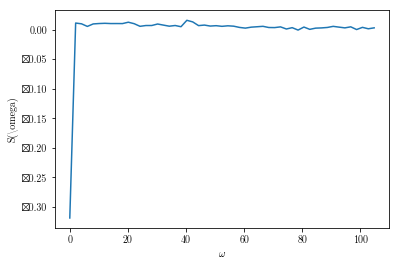

In [20]:
iQ = np.abs(Qs - 2.5).argmin()

myReconstructor = frequencyChiSquare(Ts, 
                       meanSignal = muNData[iQ,:], 
                       stdSignal  = sigmaNData[iQ,:])

myReconstructor.reconstruct()

plt.plot(myReconstructor.Ws,myReconstructor.solution['mu'])
plt.xlabel('$\omega$')
plt.ylabel(r'S(\omega)')


In [21]:
iW = myReconstructor.solution['mu'].argmax()
print myReconstructor.Ws[iW]
print myReconstructor.Ws[iW-1]
print myReconstructor.Ws[iW+1]
print 2*np.pi/myReconstructor.Ws[iW]
print 2*np.pi/myReconstructor.Ws[iW-1]
print 2*np.pi/myReconstructor.Ws[iW+1]

40.2768288922
38.2629874476
42.2906703368
0.156
0.164210526316
0.148571428571


## Updating the reconstructor object for looping over Q bins

In [33]:
myReconstructor = frequencyChiSquare(Ts, 
                       meanSignal = muNData[iQ,:], 
                       stdSignal  = sigmaNData[iQ,:], #trigType='both')
                    wMax = None)#80)

# Create an array to store reconstruction
# reconstruction = np.zeros(( Qs.shape[0],  2*myReconstructor.Ws.shape[0] ))
# reconstructionE = np.zeros(( Qs.shape[0],  2*myReconstructor.Ws.shape[0] ))
reconstruction = np.zeros(( Qs.shape[0],  myReconstructor.Ws.shape[0] ))
reconstructionE = np.zeros(( Qs.shape[0],  myReconstructor.Ws.shape[0] ))

# Now iterate over your timebins
for iQ in xrange(Qs.shape[0]):
    
    # Update reconstructor
    myReconstructor.updateInitialConditions(muNData[iQ,:], sigmaNData[iQ,:])
    
    # Run reconstructor
    myReconstructor.reconstruct()
    
    # Save solution
    reconstruction[iQ,:] = myReconstructor.solution['mu']
    reconstructionE[iQ,:] = myReconstructor.solution['sigma']
    



-1
Ignoring undefined input variable ...
['zLabel', 'zLims', 'divergent']
1.1


(1, 4.0)

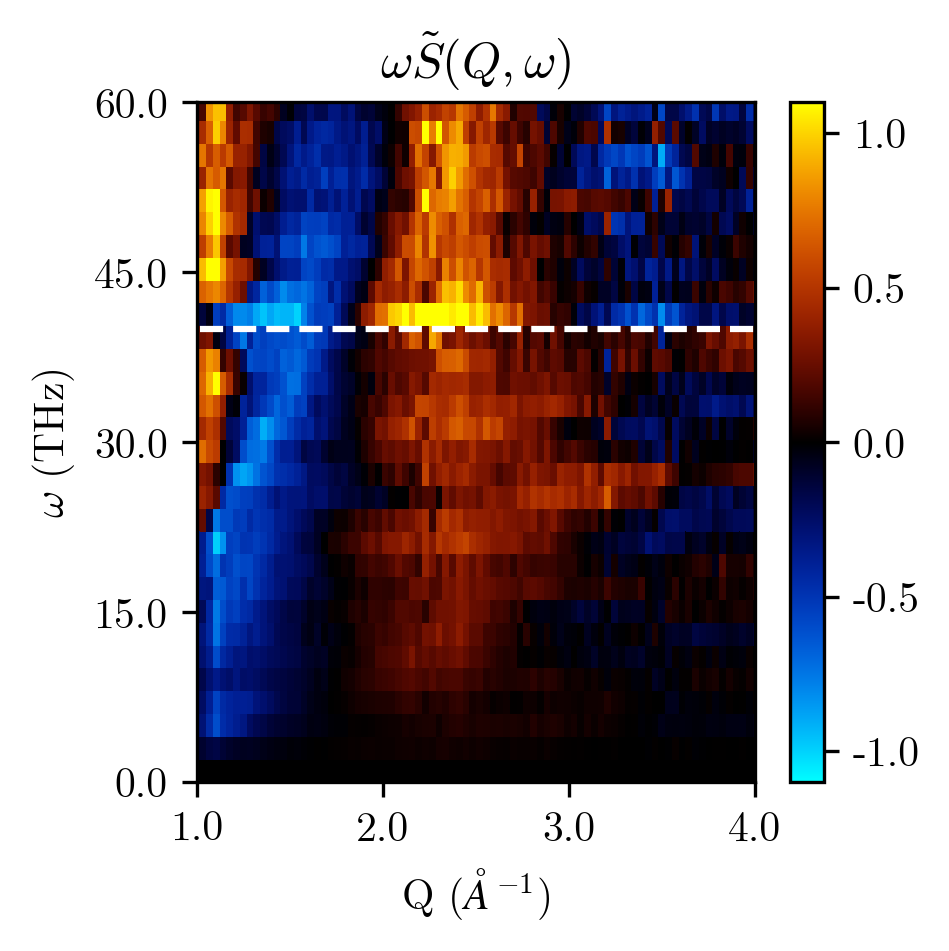

In [34]:
omega = myReconstructor.Ws

[OO, QQ] = np.meshgrid( omega, Qs )
plotMe = reconstruction[:,:omega.size]*OO
# plotMe = reconstruction[:,omega.size:]*OO

# clims = np.array([-1,1])*1.
# figOpts = {'xLims':[1.5,4.], 'yLims':[0,60], 'zLims':clims,  'yLabel':r'$\omega$', 'yUnits':'THz', 'xLabel':'Q', 'xUnits':r'$\AA^{-1}$',
#            'nxTicks':6, 'zLabel':r'$\omega S(\omega)$', 
#               'divergent':True}


clims = np.array([-1,1])
figOpts = {'xLims':[1.,4.], 'yLims':[0,60], 'zLims':clims,  'yLabel':r'$\omega$', 'yUnits':'THz', 'xLabel':'Q', 'xUnits':r'$\AA^{-1}$',
           'nxTicks':4, 'zLabel':r'$\omega \tilde{S}(Q,\omega)$', 
              'divergent':True}

colorPlot( QQ, OO, (plotMe)*2/1.2, **figOpts )


linePlot( Qs, 40*np.ones_like(Qs), newFigure=False, plotOptions={'color':'w', 'linestyle':'--'}, **figOpts )
# linePlot( Qs, 80*np.ones_like(Qs), newFigure=False, plotOptions={'color':'w', 'linestyle':'--'}, **figOpts )
# linePlot( Qs, 27*Qs-5, newFigure=False, plotOptions={'color':'w', 'linestyle':'--'}, **figOpts )
# linePlot( Qs, 16.7*Qs*np.sqrt(2), newFigure=False, plotOptions={'color':'w', 'linestyle':':'}, **figOpts )

# linePlot(Qs, 40.2768288922*np.ones_like(Qs), newFigure=False, **figOpts)

fillBackground( figOpts )

plt.xlim([1,4.])

# savefig('FTIXS-exp-800nm.eps')

In [11]:
omega[2]-omega[1]

2.0138414446088548

-1
1.1


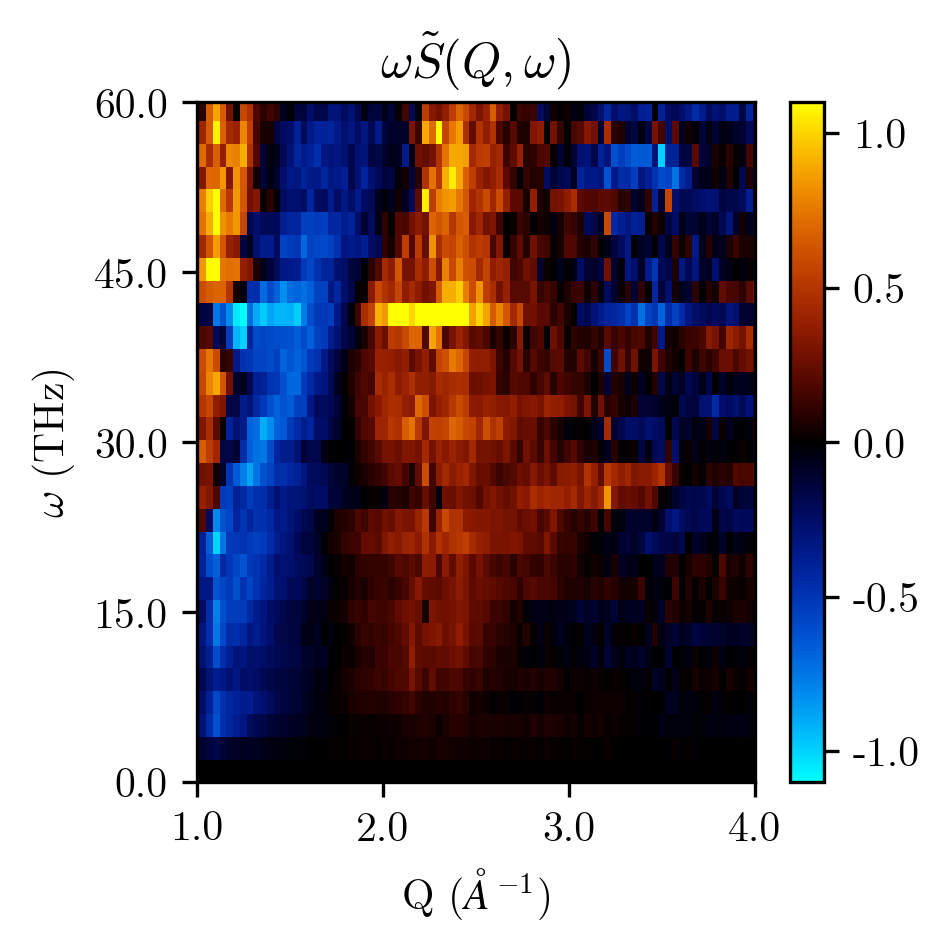

In [30]:
omega = myReconstructor.Ws

[OO, QQ] = np.meshgrid( omega, Qs )
plotMe = reconstruction[:,:omega.size]*OO
# plotMe = reconstruction[:,omega.size:]*OO

# clims = np.array([-1,1])*1.
# figOpts = {'xLims':[1.5,4.], 'yLims':[0,60], 'zLims':clims,  'yLabel':r'$\omega$', 'yUnits':'THz', 'xLabel':'Q', 'xUnits':r'$\AA^{-1}$',
#            'nxTicks':6, 'zLabel':r'$\omega S(\omega)$', 
#               'divergent':True}


clims = np.array([-1,1])
figOpts = {'xLims':[1.,4.], 'yLims':[0,60], 'zLims':clims,  'yLabel':r'$\omega$', 'yUnits':'THz', 'xLabel':'Q', 'xUnits':r'$\AA^{-1}$',
           'nxTicks':4, 'zLabel':r'$\omega \tilde{S}(Q,\omega)$', 
              'divergent':True}

colorPlot( QQ, OO, (plotMe)*2/1.2, **figOpts )


# linePlot( Qs, 40*np.ones_like(Qs), newFigure=False, plotOptions={'color':'w', 'linestyle':'--'}, **figOpts )
# linePlot( Qs, 80*np.ones_like(Qs), newFigure=False, plotOptions={'color':'w', 'linestyle':'--'}, **figOpts )
# linePlot( Qs, 27*Qs-5, newFigure=False, plotOptions={'color':'w', 'linestyle':'--'}, **figOpts )
# linePlot( Qs, 16.7*Qs*np.sqrt(2), newFigure=False, plotOptions={'color':'w', 'linestyle':':'}, **figOpts )

# linePlot(Qs, 40.2768288922*np.ones_like(Qs), newFigure=False, **figOpts)

fillBackground( figOpts )

plt.xlim([1,4.])

# savefig('FTIXS-exp-800nm-no-line.eps')

## Grab lineout right below 15 THz

In [146]:
reconstructionE[:,ind]

array([  7.48173947e-05,   2.59865488e-04,   8.58833146e-04,
         3.98934234e-04,   1.50738816e-03,   4.78583593e-03,
         3.06962220e-02,   5.39924679e-03,   6.57792993e-04,
         1.47062393e-04,   5.60065365e-05,   3.00906472e-05,
         1.52661954e-05,   1.05026704e-05,   6.53798194e-06,
         3.46460073e-06,   3.96101869e-06,   3.57065311e-06,
         1.28958479e-06,   2.71320464e-06,   4.56299315e-06,
         5.97991006e-06,   6.78962322e-06,   1.26041386e-05,
         2.07908086e-05,   3.18082989e-05,   6.17374737e-05,
         1.08872575e-04,   2.23607726e-04,   5.30593497e-04,
         9.39427812e-04,   1.63415817e-03,   1.68078418e-02,
         3.51353637e-02,   3.15198184e-01,   4.59509052e-01,
         2.61626201e-01,   5.00786327e-02,   3.03586727e-02,
         8.32384332e-03,   8.32000955e-03,   3.35737487e-03,
         1.74119648e-03,   1.21187297e-03,   6.87578766e-04,
         9.40586237e-04,   5.55725147e-04,   1.29639577e-04,
         4.72292444e-04,

20
40.2768288922
Ignoring undefined input variable ...
[]
Ignoring undefined input variable ...
[]
Ignoring undefined input variable ...
[]


(1, 4)

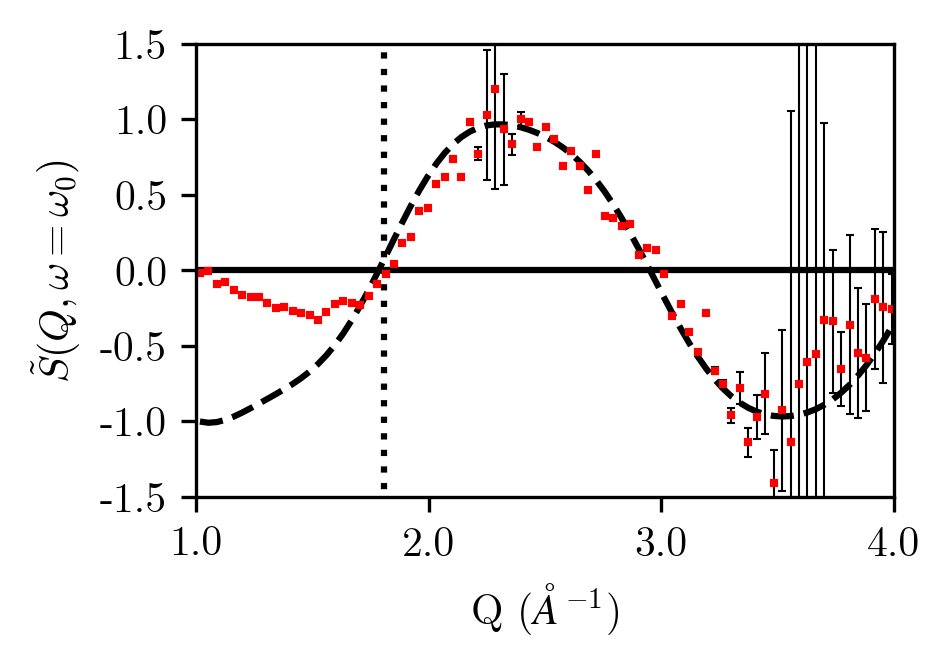

In [44]:
ind = plotMe[40,omega<60].argmax()

# ind = 45

print ind 
print omega[ind]

figOpts = {'xLims':[1.,4.], 'yLims':[-1.5,1.5], 'nxTicks':4, 'nyTicks':7,
           'yLabel':r'$\tilde{S}(Q,\omega=\omega_0)$', 'xLabel':'Q', 'xUnits':'$\AA^{-1}$'}

ys = plotMe[:,ind] * Qs**2
# linePlot(Qs, ys/ys.max()/.5, plotOpts={'linestyle':':'}, **figOpts)

q = Qs
r0 = 2.666
# r0 = 3.72

sTheory = np.cos( q*r0 ) - np.sinc(q*r0)

# sTheory = np.sin( q*r0 ) 

# linePlot(Qs, sTheory, **figOpts)

# plt.plot(Qs,sTheory)
# plt.errorbar(Qs, ys/ys[:50].max()*1.2, yerr=reconstructionE[:,ind]*Qs**2/ys[:50].max()*1.2,barsabove=True, fmt='o')


linePlot(Qs, np.zeros_like(sTheory), newFigure=True, plotOptions={'color':'k'}, **figOpts)

line,caps,bars=plt.errorbar(
    Qs,     # X
    ys/ys[:50].max()*1.2,    # Y
    yerr=reconstructionE[:,ind]*Qs**2/ys[:50].max()*1.2,        # Y-errors
    fmt="rs",    # format line like for plot()
    linewidth=3,   # width of plot line
    elinewidth=0.5,# width of error bar line
    ecolor='k',    # color of error bar
    capsize=1,     # cap length for error bar
    capthick=0.5,   # cap thickness for error bar
    ms=1
    )

# sD = load_obj('twoomega')

# linePlot( sD['Q']*1/.53, (sD['S']-1)/np.max(sD['S']-1), newFigure = False, **figOpts )

# plt.scatter(Qs, ys/ys[:50].max()*1.2, s=.8, color='red', zorder=100)
linePlot(Qs, sTheory, newFigure=False, **figOpts)

# linePlot( [4.43,4.43] , [-2,2], newFigure=False, plotOptions={'color':'k'},**figOpts )

linePlot( [1.81,1.81] , [-2,2], newFigure=False, plotOptions={'color':'k'},**figOpts )

plt.xlim([1,4])

# savefig('classical-exp-comp-800nm.eps')


In [109]:
# plotMe = tileMultiply(Qs**2, reconstruction.T).T

wFitIdxs = (myReconstructor.Ws > 20)
wFits    = myReconstructor.Ws[wFitIdxs]

data     = plotMe[:,wFitIdxs]

qFits = []
for wi, w in enumerate(xrange(wFits.shape[0])):
    qFits.append( Qs[data[:,wi].argmax()] )
#     qFits.append( Qs[data[:,wi].argmin()] )




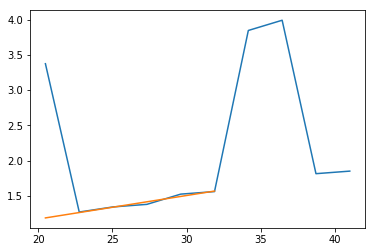

In [12]:
N = 6
pf = np.polyfit(wFits[1:N], qFits[1:N], 1)
# pf = np.polyfit(wFits[5:8], qFits[5:8], 1)
p = np.poly1d( pf )

plt.plot( wFits, qFits )
plt.plot( wFits[:N], p(wFits[:N]) )


In [232]:
pf

array([ 0.03347645,  0.50080645])

In [233]:
print slope

20.9102248548


In [234]:
1/pf[0]

29.871749792587586

In [235]:
np.pi/1.82


1.7261498096647214

In [236]:
1.82*16.7/23.3

1.3044635193133045

In [111]:
np.pi/1.3

2.41660973353061

In [25]:
import os
import os

def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)
        
find('budarzCorrection.py', sys.path[5])
# find('budarzCorrection.py', '..')

'..\\trxsToolBox\\corrections\\budarzCorrection.py'

In [6]:
d='../data/XPPL2816/'
[o for o in os.listdir(d) 
                    if os.path.isdir(os.path.join(d,o))]


[]

In [21]:


addSubDirectoriesToPath('..')